In [1]:
import matplotlib.pyplot as plt 
from collections import Counter 
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, auc
from imblearn.ensemble import BalancedBaggingClassifier

In [2]:
# Load the dataset
data_cleaned = pd.read_csv('data_cleaned.csv')

In [ ]:
corr = data_cleaned.corr()
strong_correlation_cols = [col for col in corr.columns if abs(corr.loc['HadHeartAttack', col]) >= 0.05 and col != 'HadHeartAttack']

# 检查并将映射后的列转换为整数类型
for col in data_cleaned.columns:
    if data_cleaned[col].dtype == 'object':
        print(f"Warning: Column {col} is still of type 'object'. Attempting to convert.")
    # 尝试将列转换为整数类型
    data_cleaned[col] = data_cleaned[col].astype('int', errors='ignore')

x = data_cleaned[strong_correlation_cols]
y = data_cleaned['HadHeartAttack']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape)

# 标准化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(196810, 22)


In [4]:
def knn_train(X_train, y_train):
    # 训练模型
    knn = KNeighborsClassifier(n_neighbors = 3, weights='distance')
    knn.fit(X_train, y_train)

    return knn

def bbc_train(X_train, y_train):
    bbc = BalancedBaggingClassifier(estimator=KNeighborsClassifier(n_neighbors = 5),
                                    n_estimators = 50,
                                    sampling_strategy = 'auto',
                                    replacement = False,
                                    random_state = 42)
    bbc.fit(X_train, y_train)

    return bbc

def model_predict(model, X_train, X_test):
    # 测试模型
    y_train_predict = model.predict(X_train)
    y_test_predict  = model.predict(X_test)

    return y_train_predict, y_test_predict

In [5]:
def model_metrics(model, X_train, y_train, X_test, y_test, y_train_predict, y_test_predict):
    # 计算模型评估指标
    target_classes = ['HadHeartAttack_No','HadHeartAttack_Yes']
    print("Training Dataset")
    print("_"*60)
    print(classification_report(y_train, y_train_predict, target_names = target_classes))
    print("_"*60)
    print("Training set accuracy: {:.4f}".format(model.score(X_train, y_train)))
    print("_"*60)
    print("#"*60)
    print("Testing Dataset")
    print("_"*60)
    print(classification_report(y_test, y_test_predict, target_names = target_classes))
    print("_"*60)
    print("Testing set accuracy: {:.4f}".format(model.score(X_test, y_test)))
    print("_"*60)
    print("#"*60)

In [6]:
def plot_roc_prc(model, X_test, y_test):
    # No Skill predictions (used as baseline)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc_roc = roc_auc_score(y_test, ns_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc_roc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    # Model predictions
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]

    # Calculate ROC AUC
    lr_auc_roc = roc_auc_score(y_test, lr_probs)
    print('Model: ROC AUC=%.3f' % (lr_auc_roc))
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    # Calculate PRC AUC
    precision, recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_auc_prc = auc(recall, precision)
    print('Model: PRC AUC=%.3f' % (lr_auc_prc))

    # No Skill PRC baseline
    ns_precision, ns_recall, _ = precision_recall_curve(y_test, ns_probs)

    # Plot ROC Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Model (ROC AUC={lr_auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plot PRC Curve
    plt.subplot(1, 2, 2)
    plt.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=f'Model (PRC AUC={lr_auc_prc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def plot_cm(y_test, y_test_predict):
    cm = confusion_matrix(y_test, y_test_predict)
    plt.figure(figsize=(6, 4))
    cm_matrix = pd.DataFrame(data = cm, columns = ['Predict Negative:0', 'Predict Positive:1'],
                                    index = ['Actual Negative:0', 'Actual Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

BBC Model Training Complete...
Training Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.99      0.81      0.89    186020
HadHeartAttack_Yes       0.21      0.83      0.33     10790

          accuracy                           0.81    196810
         macro avg       0.60      0.82      0.61    196810
      weighted avg       0.95      0.81      0.86    196810

____________________________________________________________
Training set accuracy: 0.8150
____________________________________________________________
############################################################
Testing Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.98      0.81      0.89     46558
HadHeartAttack_Yes       0.18      0.75      0.29      2645

          accuracy                           0.81     49

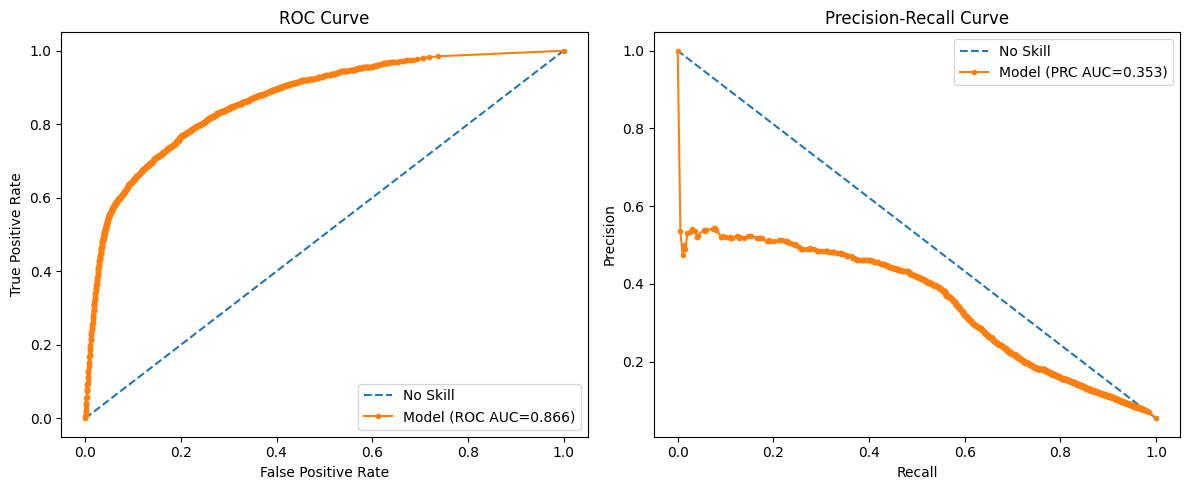

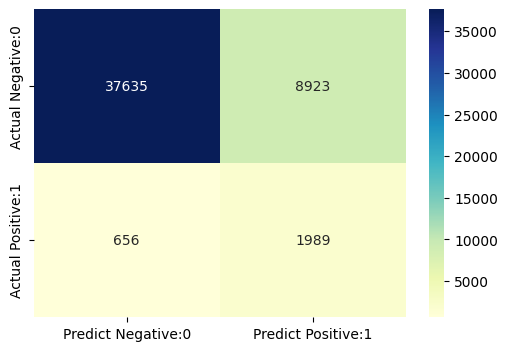

In [8]:
bbc = bbc_train(X_train, y_train)
print(f"BBC Model Training Complete...")
bbc_train_predict, bbc_test_predict = model_predict(bbc, X_train, X_test)
model_metrics(bbc, X_train, y_train, X_test, y_test, bbc_train_predict, bbc_test_predict)
plot_roc_prc(bbc, X_test, y_test)
plot_cm(y_test, bbc_test_predict)

In [9]:
print(bbc.get_params())

{'bootstrap': True, 'bootstrap_features': False, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'replacement': False, 'sampler': None, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


In [18]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
bbc = BalancedBaggingClassifier(estimator=knn, random_state=42)

# Define the parameter grid
param_grid = {
    'estimator__n_neighbors': [5],  # Number of neighbors
    'estimator__weights': ['uniform'],  # Neighbor weights
    'estimator__leaf_size': [30, 50],  # Leaf size passed to BallTree or KDTree
    'estimator__metric': ['manhattan', 'minkowski'],  # Distance metrics
    'n_estimators': [10, 50],  # Number of bagging iterations
    'sampling_strategy': ['auto']  # Resampling strategies
}

# Perform grid search
grid_search = GridSearchCV(bbc, param_grid, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__n_neighbors': 5, 'estimator__weights': 'uniform', 'n_estimators': 50, 'sampling_strategy': 'auto'}
